### Script to analyse positions and people api data on CourtListener. Specific questions:
1. How many people did we get data for? 
2. How many of these are judges?
3. What is the average number of positions for judges? What does the distribution look like? How many positions do we have across years?
4. What does the typical journey of a judge look like from their first position to a judge-ship?
5. Which court(s) have the most representation in our data?

In [1]:
# Importing the libraries
import os
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from msticpy.vis import mp_pandas_plot
from msticpy.vis.timeline import display_timeline
import networkx as nx

In [2]:
# Define the current working directory and get the path to data files
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
grandparent_dir = os.path.dirname(parent_dir)

# Define the path to the data files
data_dir = os.path.join(grandparent_dir, 'data/persons_positions')
print(data_dir)

/Users/eshan23/eshanprashar_git_profile/judges-conflicts/data/persons_positions


In [3]:
# Function to load and concatenate the csv files in our data directory defined above
def load_data(data_dir):
    '''
    This function is not memory efficient, but for <100 csv files, should work fine
    For example: this approach will have to be modified for docket/PACER data
    '''
    all_files = glob.glob(data_dir + "/*.csv")
    print(f"Found {len(all_files)} files")
    li = []
    for filename in all_files:
        try:
            df = pd.read_csv(filename, index_col=None, header=0)
            li.append(df)
        except Exception as e:
            print(f"Error loading {filename}: {e}")
    return pd.concat(li, axis=0, ignore_index=True)

In [4]:
# Define the location of csv files
path_name_csv = data_dir + '/positions_csv'

# Load the data
df_persons_positions = load_data(path_name_csv)

# Examine the data obtained
df_persons_positions.info()

Found 26 files
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51281 entries, 0 to 51280
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   person_id               51281 non-null  int64  
 1   name_first              51281 non-null  object 
 2   name_middle             43300 non-null  object 
 3   name_last               51281 non-null  object 
 4   political_affiliations  35456 non-null  object 
 5   race                    33919 non-null  object 
 6   position_url            51281 non-null  object 
 7   position_type           30056 non-null  object 
 8   job_title               21225 non-null  object 
 9   sector                  6764 non-null   float64
 10  organization            13248 non-null  object 
 11  date_nominated          4274 non-null   object 
 12  date_start              50412 non-null  object 
 13  date_termination        42457 non-null  object 
 14  court_resource_url     

In [5]:
# Examining null values for each column
for col in df_persons_positions.columns:
    print(f"Column: {col} has:") 
    print(f"{df_persons_positions[col].nunique()} unique values")
    print(f"{df_persons_positions[col].isnull().sum()} null values")
    print("=====================================")

Column: person_id has:
15604 unique values
0 null values
Column: name_first has:
2268 unique values
0 null values
Column: name_middle has:
2429 unique values
7981 null values
Column: name_last has:
8522 unique values
0 null values
Column: political_affiliations has:
8 unique values
15825 null values
Column: race has:
18 unique values
17362 null values
Column: position_url has:
51281 unique values
0 null values
Column: position_type has:
45 unique values
21225 null values
Column: job_title has:
4439 unique values
30056 null values
Column: sector has:
2 unique values
44517 null values
Column: organization has:
6444 unique values
38033 null values
Column: date_nominated has:
2133 unique values
47007 null values
Column: date_start has:
7204 unique values
869 null values
Column: date_termination has:
6259 unique values
8824 null values
Column: court_resource_url has:
1033 unique values
29107 null values
Column: court_id has:
1033 unique values
29107 null values
Column: court_short_name has:

### Observations from data analysis:
1. For the ~21K null values in the column "position_type", there is a value in the column "job_title". The opposite is also true, which they are MECE
2. Because of the point above, we should create a column called "position" which has value in either of the "job_title" or "position_type" columns
3. When there's a value in position_type, the columns court_id, court_short_name and long_name are populated, they aren't when position is blank and job_title has values 

### Questions to start with:
1. How many people did we get data for? -> 15,604 people 
2. How many of these are judges?
3. What is the average number of positions for judges? What does the distribution look like? How many positions do we have across years?

### All data modifications before exporting file in the next cell

In [6]:
# First, we add a new column in the dataframe combining values from "position_type" and "job_title"
# If position_type is null, we will use "job_title" only and vice-versa

df_persons_positions['position'] = df_persons_positions['position_type'].fillna('') + ' ' + df_persons_positions['job_title'].fillna('')

# Next, we convert the "position" column to lowercase and remove any leading/trailing whitespaces
df_persons_positions['position'] = df_persons_positions['position'].str.lower().str.strip()

# Add a column called "judge flag" to the dataframe. This will be 1 if the position contains "jud" and 0 otherwise
df_persons_positions['judge_flag'] = df_persons_positions['position'].str.contains('jud', na=False).astype(int)

In [7]:
# Export this dataframe to csv for further analysis
df_persons_positions.to_csv(data_dir + '/persons_positions_modified.csv', index=False)

In [ ]:
# Examining the unique values in the "position" column
print(f"Total unique positions are {df_persons_positions['position'].nunique()}")

# Total unique positions with the string "jud" in them
print(f"Total unique positions with 'jud' in them are {df_persons_positions[df_persons_positions['position'].str.contains('jud', na=False)]['position'].nunique()}")

In [22]:
# Let's find the average number of positions (rows) per person_id
avg_positions = df_persons_positions.groupby('person_id').size().mean()
print(f"Average number of positions per person_id is {avg_positions.round(2)}")

# Let's find the median number of positions per person_id
median_positions = df_persons_positions.groupby('person_id').size().median()
print(f"Median number of positions per person_id is {median_positions}")

Average number of positions per person_id is 3.29
Median number of positions per person_id is 2.0


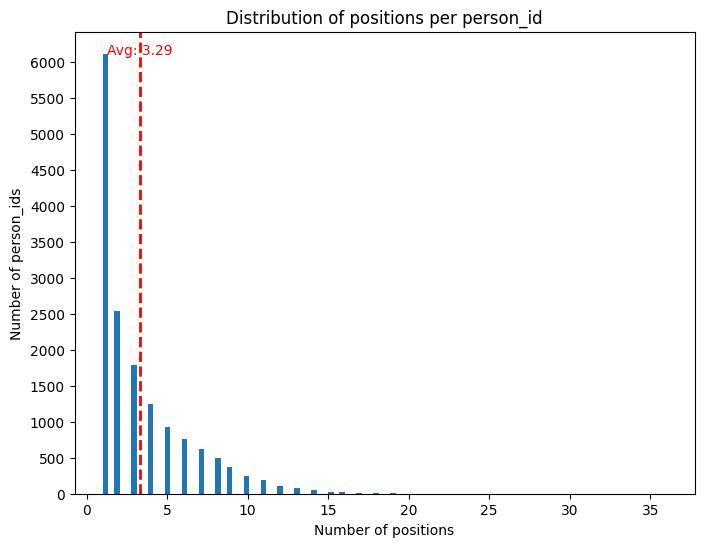

In [19]:
# Let's also plot the distribution of rows (positions) for each person_id

# Plot the distribution of rows (positions) for each person_id
plt.figure(figsize=(8,6))
df_persons_positions.groupby('person_id').size().plot(kind='hist', bins=100)
plt.xlabel('Number of positions')
plt.ylabel('Number of person_ids')
plt.title('Distribution of positions per person_id')

# Set Y-axis ticks to intervals of 500
max_y = plt.gca().get_ylim()[1]  # Get the current upper limit of the Y-axis
plt.yticks(range(0, int(max_y) + 1, 500))

# Plot the average value as a vertical line
plt.axvline(avg_positions, color='r', linestyle='dashed', linewidth=2)
plt.text(avg_positions, max_y * 0.95, f'Avg: {avg_positions:.2f}', color='r', ha='center')

plt.show()

Out of 15.6K people, 14.2K have the title judge associated with them. What about the rest? What positions do they have?
To tackle this, we can think of the positions as judge and non-judge. We can find:
1. Number of people with only judge positions
2. Number of people with only non-judge positions (also check what these positions are)
3. Number of people with both judge and non-judge positions 

The last category of people is of value. For this category of people, we will check:
1. Average number of positions
2. Types of positions just before, just after judge position; n +/- 2 positions and so on

In [33]:
# Now, let's find count of person_ids that ONLY have judge flag = 1. These people have no other positions in the data
judges_venn = df_persons_positions.groupby('person_id')['judge_flag'].sum()

# Check if the sum of judge_flag for each person_id is equal to the number of positions they have (indicating all positions are judge-related)
only_judges_count = (judges_venn == df_persons_positions.groupby('person_id').size()).sum()

# Now, let's find count of person_ids that ONLY have judge flag = 0. These people are NOT JUDGES
# Sum of judge_flag for each person_id is 0
only_non_judges_count = (judges_venn == 0).sum()

# Now, let's find count of person_ids that have judge flag = 1 as well as 0. These are judges with other positions, this is data we care about
# Check if the sum of judge_flag for each person_id is greater than 0 and less than the number of positions they have
judges_with_other_positions_count = ((judges_venn > 0) & (judges_venn < df_persons_positions.groupby('person_id').size())).sum()

# Print all values
print(f"Total number of person_ids: {df_persons_positions['person_id'].nunique()}")
print(f"Count of person_ids that ONLY have judge flag = 1: {only_judges_count}")
print(f"Count of person_ids that ONLY have judge flag = 0: {only_non_judges_count}")
print(f"Count of person_ids that have judge flag = 1 as well as 0: {judges_with_other_positions_count}")

Total number of person_ids: 15604
Count of person_ids that ONLY have judge flag = 1: 6912
Count of person_ids that ONLY have judge flag = 0: 1325
Count of person_ids that have judge flag = 1 as well as 0: 7367


Now that we have split data into 3 parts, let's check:
1. For non-judges, names of positions and their counts
2. For judges with other positions, the average number of positions per person

In [35]:
# Positions and counts for non-judges 
non_judges = df_persons_positions[df_persons_positions['person_id'].isin(judges_venn[judges_venn == 0].index)]
non_judge_positions_count = non_judges['position'].value_counts()

# Print top 20 non-judge positions
print("\nNon-Judge Positions and Their Counts:")
print("=====================================")
print(non_judge_positions_count.head(20))

# For judges with other positions, the average number of positions per person
judges_with_other_positions = df_persons_positions[df_persons_positions['person_id'].isin(judges_venn[(judges_venn > 0) & (judges_venn < df_persons_positions.groupby('person_id').size())].index)]
average_positions_judges_with_others = judges_with_other_positions.groupby('person_id').size().mean()
print(f"\nAverage number of positions per judge with other positions: {average_positions_judges_with_others:.2f}")


Non-Judge Positions and Their Counts:
position
mag                          925
jus                          189
prac                         166
mayor                        134
ass-jus                       67
partner                       52
pres                          43
clerk                         41
gov                           25
adj-prof                      24
ada                           23
c-jus                         20
assistant u.s. attorney       11
act-jus                        9
assistant public defender      7
com                            6
pres-jus                       5
surrogate                      5
c-mag                          5
counsel                        5
Name: count, dtype: int64

Average number of positions per judge with other positions: 5.35


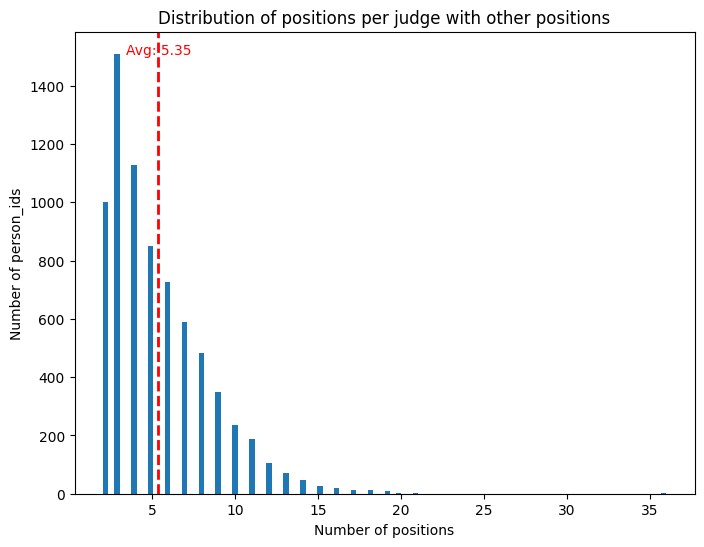

In [37]:
# Let's now draw the histogram of the number of positions for judges with other positions
plt.figure(figsize=(8,6))
judges_with_other_positions.groupby('person_id').size().plot(kind='hist', bins=100)
plt.xlabel('Number of positions')
plt.ylabel('Number of person_ids')
plt.title('Distribution of positions per judge with other positions')

# Plot the average value as a vertical line
plt.axvline(average_positions_judges_with_others, color='r', linestyle='dashed', linewidth=2)
plt.text(average_positions_judges_with_others, plt.gca().get_ylim()[1] * 0.95, f'Avg: {average_positions_judges_with_others:.2f}', color='r', ha='center')

plt.show()

For n=7,367 judges who have other positions, we want to see their n-1,2,3 positions. For this, we will have to sort data by "date_started" wherever it is available. 
* Where it is not available, we will not use the position - this decision can be changed

/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_62362/3237091852.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['judge_flag'] = df_filtered['position'].str.contains('jud', na=False).astype(int)
/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_62362/3237091852.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  judges_with_other_positions['date_start'] = pd.to_datetime(judges_with_other_positions['date_start'], errors='coerce')


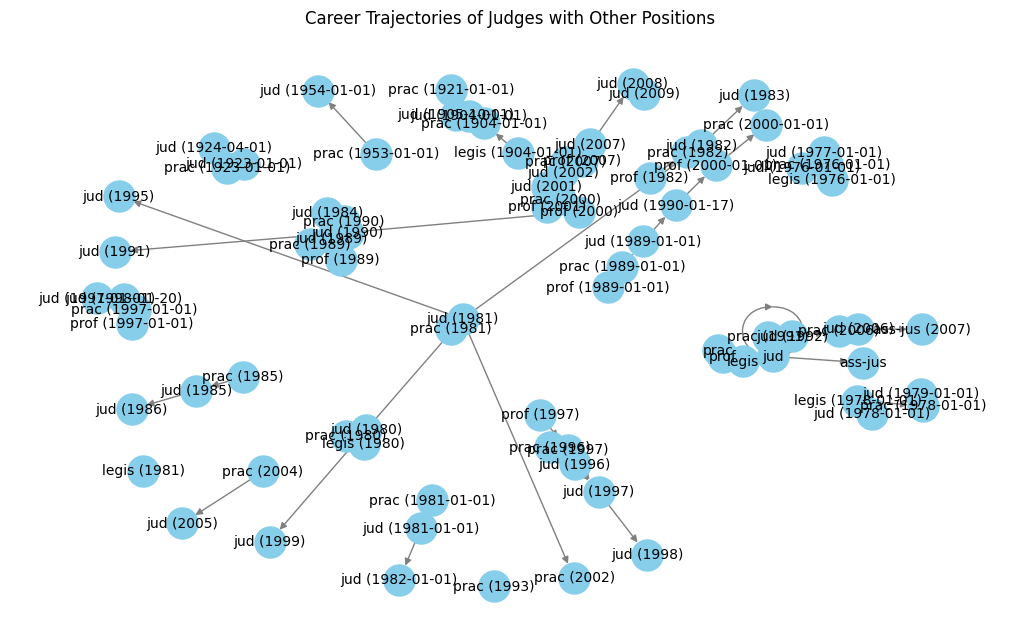

In [73]:
# Filter the DataFrame to include only x unique person_ids
x= 50
unique_person_ids = df_persons_positions['person_id'].unique()[:x]
df_filtered = df_persons_positions[df_persons_positions['person_id'].isin(unique_person_ids)]

# Filter judges with other positions
df_filtered['judge_flag'] = df_filtered['position'].str.contains('jud', na=False).astype(int)
judges_venn_sample = df_filtered.groupby('person_id')['judge_flag'].sum()
judges_with_other_positions = df_filtered[df_filtered['person_id'].isin(judges_venn_sample[(judges_venn_sample > 0) & (judges_venn_sample < df_filtered.groupby('person_id').size())].index)]

# Convert date columns to datetime
judges_with_other_positions['date_start'] = pd.to_datetime(judges_with_other_positions['date_start'], errors='coerce')

# Filter the DataFrame to include only start dates between 1980 and 2024
start_date_filter = (judges_with_other_positions['date_start'] >= '1980-01-01') & (judges_with_other_positions['date_start'] <= '2024-12-31')
filtered_df = judges_with_other_positions[start_date_filter]

# Add nodes and edges based on date_start
for person_id, group in filtered_df.groupby('person_id'):
    group = group.sort_values(by='date_start')
    prev_position = None
    for _, row in group.iterrows():
        # Extract the year from the date_start column
        year = row['date_start'].year
        # position_label = f"{row['position']} ({year})" # This doesn't seem to be working properly
        position_label = row['position']
        G.add_node(position_label, label=position_label)
        if prev_position:
            G.add_edge(prev_position, position_label)
        prev_position = position_label

# Plot the graph
plt.figure(figsize=(10,6))
pos = nx.spring_layout(G)  # positions for all nodes
nx.draw(G, pos, with_labels=True, node_size=500, node_color="skyblue", font_size=10, edge_color='gray')
plt.title("Career Trajectories of Judges with Other Positions")
plt.show()

In [62]:
# Convert date columns to datetime
unique_person_ids = df_persons_positions['person_id'].unique()[:100]
df_filtered = df_persons_positions[df_persons_positions['person_id'].isin(unique_person_ids)]
df_filtered['date_start'] = pd.to_datetime(df_filtered['date_start'], errors='coerce')

# Filter the DataFrame to include only start dates between 1980 and 2024
start_date_filter = (judges_with_other_positions['date_start'] >= '1980-01-01') & (judges_with_other_positions['date_start'] <= '2024-12-31')
filtered_df = judges_with_other_positions[start_date_filter]

# Preparing the columns for analysis
df_filtered['Event'] = df_filtered['position']
df_filtered['Start'] = pd.to_datetime(df_filtered['date_start'], errors='coerce')
df_filtered['Source'] = df_filtered['person_id'].astype(str)

# Plot the timeline
display_timeline(
    data=df_filtered,
    title="Career Trajectories of Judges with Other Positions",
    group_by='Event',  # Group by position names
    time_column='Start', 
    source_columns=['Source', 'person_id'],  # Include person_id in hover data
    height=400,
    width=800
)

/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_62362/2474939830.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['date_start'] = pd.to_datetime(df_filtered['date_start'], errors='coerce')
/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_62362/2474939830.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Event'] = df_filtered['position']
/var/folders/54/mhs5zkcs6zb1_y58hd7pczjc0000gn/T/ipykernel_62362/2474939830.py:12: SettingWithCopyWarning: 
A value is tr

Loading BokehJS ...

Column(id='p51738', ...)

In [72]:
# Calculating null values for date_start column in judges_with_other_positions dataframe
judges_with_other_positions = df_persons_positions[df_persons_positions['person_id'].isin(judges_venn[(judges_venn > 0) & (judges_venn < df_persons_positions.groupby('person_id').size())].index)]
null_date_start = judges_with_other_positions['date_start'].isnull().sum()
print(f"Total rows in judges_with_other_positions dataframe: {judges_with_other_positions.shape[0]}")
print(f"Number of null values in date_start column: {null_date_start}")

Total rows in judges_with_other_positions dataframe: 39448
Number of null values in date_start column: 690
